In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
config_df = pd.read_csv("sbert.csv")
epoch_df = pd.read_csv("sbert_epoch.csv")
epoch_df.head()
config_df.head()

,config_id,type_test,model_name,dataset_type,pooling_type,batch_size,epochs,learning_rate,attention_dropout,hidden_dropout,...,peak_memory,reg_train_loss,reg_train_rmse,reg_train_pearson,reg_valid_loss,reg_valid_rmse,reg_valid_pearson,reg_test_loss,reg_test_rmse,reg_test_pearson
0,0,model_test,sentence-transformers/distiluse-base-multiling...,before balancing,mean,16,13,0.00002,0.1,0.1,...,7543.489746,0.001077,0.032812,0.991458,0.010192,0.100956,0.926784,0.009593,0.097943,0.928017
1,1,model_test,sentence-transformers/distiluse-base-multiling...,after balancing,mean,16,7,0.00002,0.1,0.1,...,7543.489746,0.001267,0.035589,0.992400,0.011061,0.105173,0.920975,0.010299,0.101482,0.923226


# Training Plot

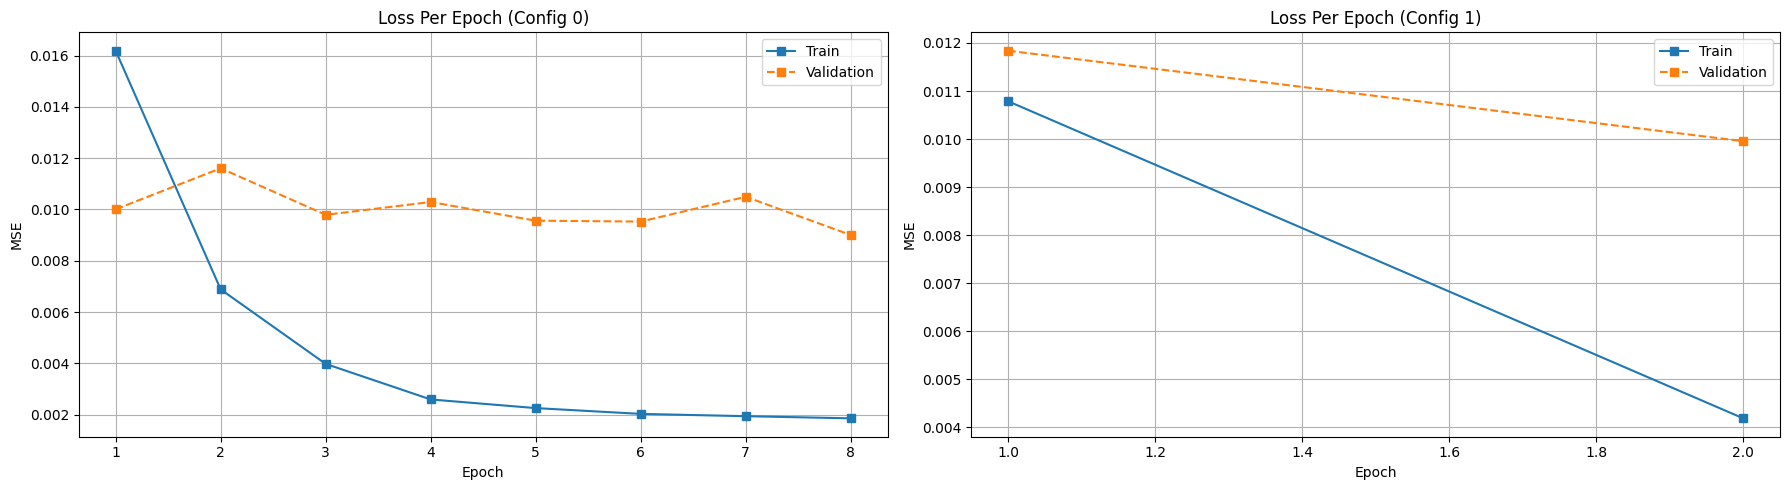

In [3]:
metrics = ['mse']
titles = {
    'mse': 'Loss Per Epoch'
}

fig, axes = plt.subplots(1, 2, figsize=(18, 5))  # 1 row, 3 columns

for i, row in enumerate(config_df.itertuples(index=False)):
    
    config_id = row.config_id
    data = epoch_df[epoch_df['config_id'] == config_id]
    
    epochs = data['epoch'].iloc[:-5]
    
    for metric in metrics:
        train_metric = data[f'train_{metric}'].iloc[:-5]
        valid_metric = data[f'valid_{metric}'].iloc[:-5]

        ax = axes[i]
        ax.plot(epochs, train_metric, linestyle='-', marker='s', label='Train')
        ax.plot(epochs, valid_metric, linestyle='--', marker='s', label='Validation')
        
        ax.set_title(f"{titles[metric]} (Config {config_id})")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(metric.upper())
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()


# Scatter Plot with Regression Line

In [4]:
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', '..'))
sys.path.append(src_path)
from transformers import AutoTokenizer
from main_similarity import SiameseModel, AutomaticScoringDataset
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
import joblib

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/distiluse-base-multilingual-cased-v2")
model = SiameseModel("sentence-transformers/distiluse-base-multilingual-cased-v2").to('cuda')

def compute_cosine_similarity(dataloader, model):
        all_outputs = []
        all_scores = []
        with torch.no_grad():
            for batchs in dataloader:
                batchs = {
                    k: {kk: vv.to("cuda") for kk, vv in v.items()} if isinstance(v, dict) else v.to("cuda")
                    for k, v in batchs.items()
                }
                
                # get embedding for each student and reference answer
                reference_emb = model(batchs['reference_answer']['input_ids'], batchs['reference_answer']['attention_mask'])
                student_emb = model(batchs['student_answer']['input_ids'], batchs['student_answer']['attention_mask'])
                scores = batchs['labels'].float().view(-1)

                # Normalize embeddings
                ref_embedding = F.normalize(reference_emb, p=2, dim=1)
                student_embedding = F.normalize(student_emb, p=2, dim=1)

                # get cosine similarity
                similarity = F.cosine_similarity(ref_embedding, student_embedding, dim=1)
                similarity = torch.clamp(similarity, -1.0, 1.0)

                all_outputs.append(similarity)
                all_scores.append(scores)

        # Concatenate all batches
        X = torch.cat(all_outputs, dim=0).cpu().numpy()
        y = torch.cat(all_scores, dim=0).cpu().numpy()

        return X, y

def predict(df_test, config_id):
    test_data = AutomaticScoringDataset(df_test, tokenizer)
    test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False, generator=torch.Generator().manual_seed(42), num_workers=0)
    
    checkpoint = torch.load(f"../../../models/balancing/spesific/sbert_{config_id}.pt", map_location='cuda', weights_only=True)
    reg_model = joblib.load(f"../../../models/balancing/spesific/reg_{config_id}.pkl")
    model.load_state_dict(checkpoint)
    model.eval()
    X_test, y_test = compute_cosine_similarity(test_dataloader, model)
    y_test_pred = reg_model.predict(X_test.reshape(-1, 1))

    return y_test_pred, y_test

def save_predictions(df_test, output_path):
    columns_to_keep = ['question', 'reference_answer', 'answer', 'normalized_score', 'dataset_num']
    columns_to_keep += [col for col in df_test.columns if col.startswith("predicted_score_")]
    df_test = df_test[columns_to_keep]
    df_test.to_csv(output_path, index=False)

In [5]:
import pandas as pd

df_test = pd.read_csv("../../../../data/clean/spesific/test_indo.csv")
for row in config_df.itertuples():
    all_predictions, all_targets = predict(df_test, row.config_id)

    # Tambahkan prediksi ke df_test
    df_test[f"predicted_score_{row.config_id}"] = all_predictions

output_dir = "inference"
os.makedirs(output_dir, exist_ok=True)

save_predictions(df_test, os.path.join(output_dir, "sbert_prediction.csv"))

c:\Users\User\Documents\Code\env\lib\site-packages\transformers\models\distilbert\modeling_distilbert.py:402: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(



>> Tanpa Augmentasi
RMSE: 0.1024, Pearson: 0.9222

>> Dengan Augmentasi
RMSE: 0.0996, Pearson: 0.9285


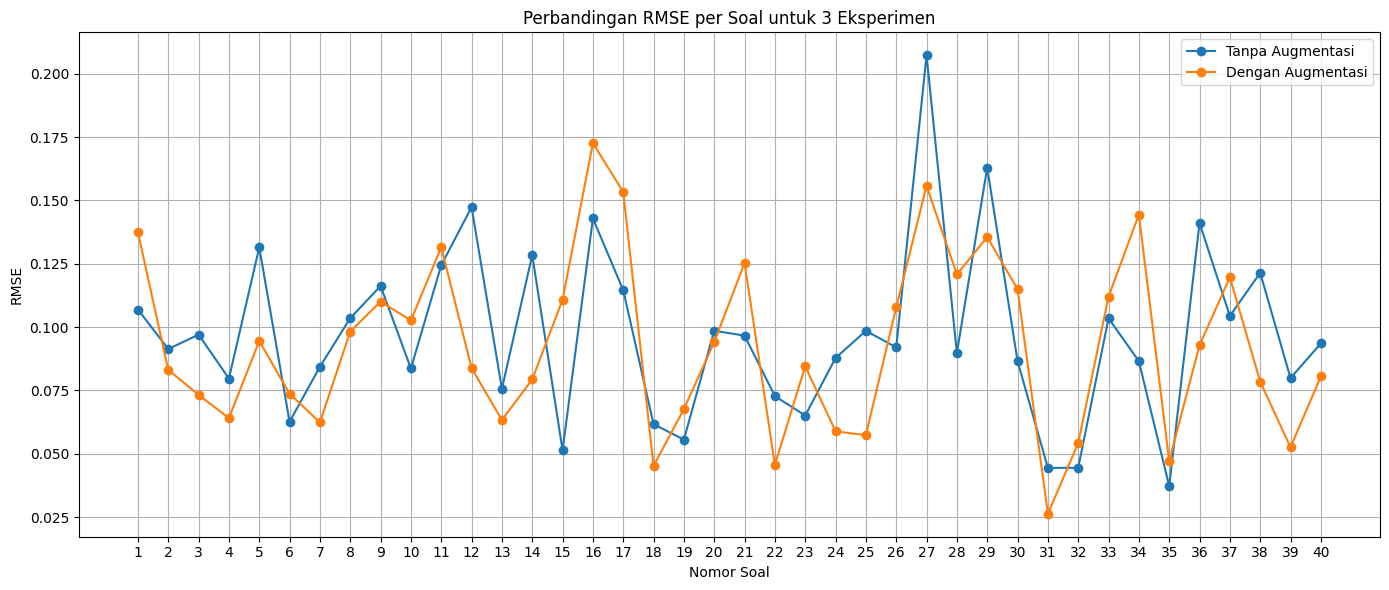

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from scipy.stats import pearsonr
from tabulate import tabulate

# Folder inference
inference_dir = "inference"
csv_files = [f for f in os.listdir(inference_dir) if f.endswith(".csv") and f.startswith("sbert")]

# Warna akan di-generate otomatis tergantung jumlah eksperimen
color_palette = plt.get_cmap("tab10")  # Bisa memuat hingga 10 warna berbeda

# Label eksperimen bisa ditentukan manual berdasarkan nama kolom prediksi
label_map = {
    "predicted_score_0": "Tanpa Augmentasi",
    "predicted_score_1": "Dengan Augmentasi",
}

# Dictionary untuk menyimpan RMSE per soal dari tiap eksperimen
rmse_per_model = {}
metric_eval_data = {}
# Buat scatter plot dan hitung RMSE per soal
model_idx = 0
for file in csv_files:
    file_path = os.path.join(inference_dir, file)
    df = pd.read_csv(file_path)

    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values
        residuals = pred_scores - true_scores

        # Hitung metrik global
        rmse = root_mean_squared_error(true_scores, pred_scores)
        pearson, _ = pearsonr(true_scores, pred_scores)

        label = label_map.get(col, col)  # Default pakai nama kolom kalau tidak ditemukan
        print(f"\n>> {label}")
        print(f"RMSE: {rmse:.4f}, Pearson: {pearson:.4f}")

        metric_eval_data[label] = {
            "RMSE": round(rmse, 4),
            "Pearson": round(pearson, 4)
        }

        # Hitung RMSE per soal
        rmse_per_soal = df.groupby('dataset_num').apply(lambda x: root_mean_squared_error(x['normalized_score'], x[col]), include_groups=False)
        rmse_per_model[label] = rmse_per_soal
        model_idx += 1

# Ekstrak nomor soal dari dataset_num (misalnya 'analisis_essay-19' -> 19)
def extract_soal_number(index_series):
    return index_series.astype(str).str.extract(r'(\d+)$').astype(int)[0]

# Plot gabungan RMSE per soal
plt.figure(figsize=(14, 6))
for i, label in enumerate(rmse_per_model):
    rmse_series = rmse_per_model[label]
    
    # Ekstrak nomor soal
    soal_numbers = extract_soal_number(rmse_series.index)
    
    # Gabungkan kembali ke Series dengan index numerik
    rmse_series.index = soal_numbers
    rmse_series = rmse_series.sort_index()
    
    # Plot
    plt.plot(rmse_series.index, rmse_series.values, marker='o', linestyle='-', label=label)

plt.title("Perbandingan RMSE per Soal untuk 3 Eksperimen")
plt.xlabel("Nomor Soal")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.xticks(ticks=sorted(rmse_series.index.unique()))  # Lebih rapi dan terbaca
plt.tight_layout()
plt.show()



In [7]:
fixed_threshold = 0.1

model_data = []

for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values
        residuals = pred_scores - true_scores
        label = label_map.get(col, col)
        model_data.append((label, true_scores, pred_scores, residuals))

model_data = sorted(model_data, key=lambda x: x[0])


# Visualisasi scatter plot untuk tiap model
num_models = len(model_data)
outlier_count = {}

for i, (label, true_scores, pred_scores, residuals) in enumerate(model_data):
    # Deteksi outlier IQR global & fixed threshold
    outlier_fixed2 = np.abs(residuals) > 0.2
    outlier_fixed = np.abs(residuals) > fixed_threshold

        # Hitung jumlah outlier
    num_outliers_fixed2 = np.sum(outlier_fixed2)
    num_outliers_fixed = np.sum(outlier_fixed)

    # Cetak hasil
    print(f"{label}:")
    print(f"  Outlier (Fixed ±0.2): {num_outliers_fixed2}")
    print(f"  Outlier (Fixed ±{fixed_threshold}): {num_outliers_fixed}\n")
    outlier_count[label] = {
        "IQR Fixed Threshold ±0.2": num_outliers_fixed2,
        "IQR Fixed Threshold ±0.1": num_outliers_fixed
    }

Dengan Augmentasi:
  Outlier (Fixed ±0.2): 16
  Outlier (Fixed ±0.1): 50

Tanpa Augmentasi:
  Outlier (Fixed ±0.2): 14
  Outlier (Fixed ±0.1): 58



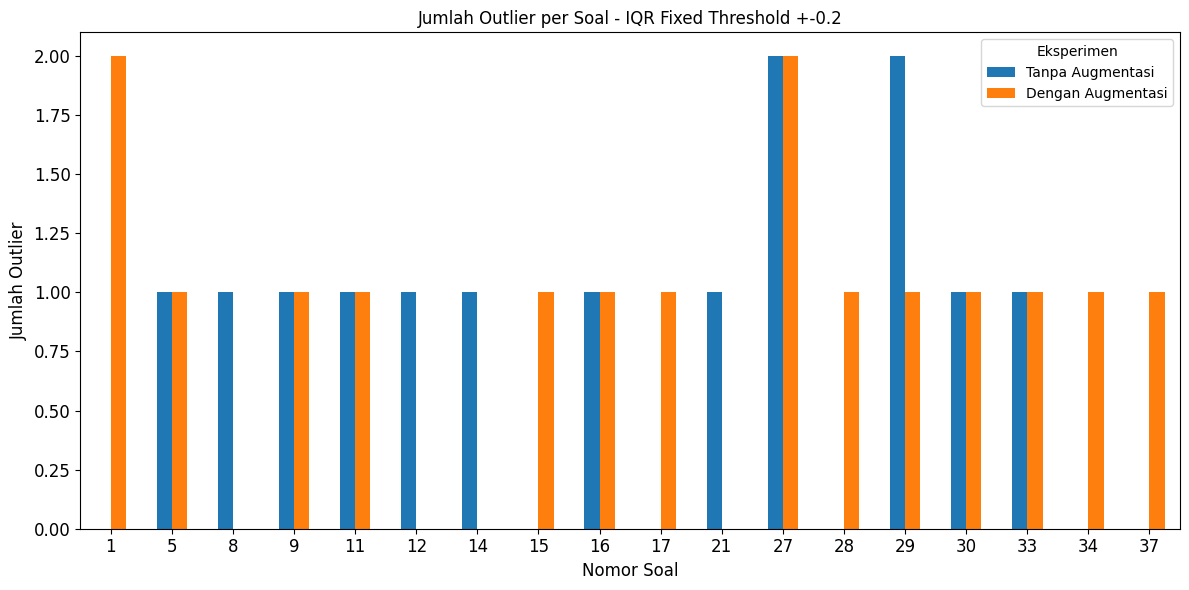

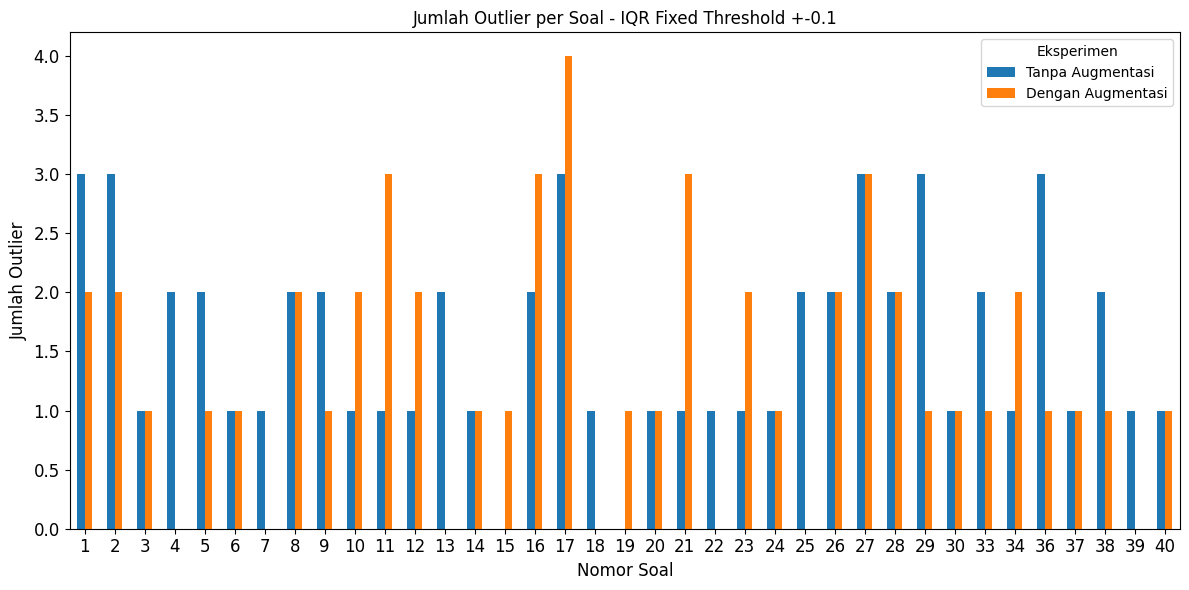

In [14]:
outlier_counts_fixed1 = {}
outlier_counts_fixed2 = {}

# Fixed threshold
fixed_threshold1 = 0.1
fixed_threshold2 = 0.2

# Step 3: Hitung jumlah outlier per soal (IQR Global & Fixed)
for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]
    df['soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)

    for col in pred_cols:
        residuals = df[col].values - true_scores

        outlier_mask_fixed1 = np.abs(residuals) > fixed_threshold1
        outlier_mask_fixed2 = np.abs(residuals) > fixed_threshold2

        df['outlier_fixed1'] = outlier_mask_fixed1
        df['outlier_fixed2'] = outlier_mask_fixed2

        label = label_map.get(col, col)

        # Fixed Threshold
        fixed_counts1 = df[df['outlier_fixed1']].groupby('soal_num').size()
        outlier_counts_fixed1[label] = fixed_counts1

        fixed_counts2 = df[df['outlier_fixed2']].groupby('soal_num').size()
        outlier_counts_fixed2[label] = fixed_counts2

df_fixed1 = pd.DataFrame(outlier_counts_fixed1).fillna(0).astype(int).sort_index()
df_fixed2 = pd.DataFrame(outlier_counts_fixed2).fillna(0).astype(int).sort_index()

# Plot 1: IQR Global
fig2, ax2 = plt.subplots(figsize=(12, 6))
df_fixed2.plot(kind='bar', ax=ax2)
ax2.set_title("Jumlah Outlier per Soal - IQR Fixed Threshold +-0.2", fontsize=12)
ax2.set_xlabel("Nomor Soal", fontsize=12)
ax2.set_ylabel("Jumlah Outlier", fontsize=12)
ax2.legend(title="Eksperimen")
ax2.tick_params(axis='x', labelsize=12, rotation=0)
ax2.tick_params(axis='y', labelsize=12)
plt.tight_layout()
plt.show()

fig1, ax1 = plt.subplots(figsize=(12, 6))
df_fixed1.plot(kind='bar', ax=ax1)
ax1.set_title("Jumlah Outlier per Soal - IQR Fixed Threshold +-0.1", fontsize=12)
ax1.set_xlabel("Nomor Soal", fontsize=12)
ax1.set_ylabel("Jumlah Outlier", fontsize=12)
ax1.legend(title="Eksperimen")
ax1.tick_params(axis='x', labelsize=12, rotation=0)
ax1.tick_params(axis='y', labelsize=12)
plt.tight_layout()
plt.show()

In [15]:
print("Metrik Evaluation")
print(metric_eval_data)
print("Jumlah Outlier Per Metode IQR")
print(outlier_count)
print("Jumlah Outlier Per Soal Metode IQR Fixed Threshold +-0.1")
print(df_fixed1.to_json())
print("Jumlah Outlier Per Soal Metode IQR Fixed Threshold +-0.2")
print(df_fixed2.to_json())

Metrik Evaluation
{'Tanpa Augmentasi': {'RMSE': 0.1024, 'Pearson': 0.9222}, 'Dengan Augmentasi': {'RMSE': 0.0996, 'Pearson': 0.9285}}
Jumlah Outlier Per Metode IQR
{'Dengan Augmentasi': {'IQR Fixed Threshold ±0.2': 16, 'IQR Fixed Threshold ±0.1': 50}, 'Tanpa Augmentasi': {'IQR Fixed Threshold ±0.2': 14, 'IQR Fixed Threshold ±0.1': 58}}
Jumlah Outlier Per Soal Metode IQR Fixed Threshold +-0.1
{"Tanpa Augmentasi":{"1":3,"2":3,"3":1,"4":2,"5":2,"6":1,"7":1,"8":2,"9":2,"10":1,"11":1,"12":1,"13":2,"14":1,"15":0,"16":2,"17":3,"18":1,"19":0,"20":1,"21":1,"22":1,"23":1,"24":1,"25":2,"26":2,"27":3,"28":2,"29":3,"30":1,"33":2,"34":1,"36":3,"37":1,"38":2,"39":1,"40":1},"Dengan Augmentasi":{"1":2,"2":2,"3":1,"4":0,"5":1,"6":1,"7":0,"8":2,"9":1,"10":2,"11":3,"12":2,"13":0,"14":1,"15":1,"16":3,"17":4,"18":0,"19":1,"20":1,"21":3,"22":0,"23":2,"24":1,"25":0,"26":2,"27":3,"28":2,"29":1,"30":1,"33":1,"34":2,"36":1,"37":1,"38":1,"39":0,"40":1}}
Jumlah Outlier Per Soal Metode IQR Fixed Threshold +-0.2
{"T

In [13]:
# import json

# interesting_num = [16, 29, 37]
# for file in csv_files:
#     df = pd.read_csv(os.path.join(inference_dir, file))
#     true_scores = df['normalized_score'].values
#     pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]
#     df['soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)

#     for col in pred_cols:
#         residuals = df[col].values - true_scores
#         outlier_mask = np.abs(residuals) > fixed_threshold

#         subset_iqr = df[outlier_mask][['soal_num', 'question', 'reference_answer', 'answer', 'normalized_score', col]]
#         subset_iqr = subset_iqr[subset_iqr['soal_num'].isin(interesting_num)]
#         if not subset_iqr.empty:
#             print(f"\nIQR Outliers untuk eksperimen: {label_map.get(col, col)}")
#             print(subset_iqr.to_json(orient="records", indent=2, force_ascii=False))
